In [1]:
# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from feature_extraction import sketch_token_features
from utils import nsd_utils, roi_utils, default_paths

from model_fitting import initialize_fitting as initialize_fitting
import matplotlib.pyplot as plt

fpX = np.float32
device = 'cpu:0'

In [2]:
fitting_type='sketch_tokens';
subject=1; volume_space = True; up_to_sess = 1;
sample_batch_size = 50; voxel_batch_size = 100; \

zscore_features = True; zscore_in_groups = False; ridge = True; \
shuffle_images = False; random_images = False; random_voxel_data = False; \
do_fitting = True; use_precomputed_prfs = False; do_val = True; do_stack=True; \
do_varpart = True; do_roi_recons=False; do_voxel_recons=False; date_str = 0; \

shuff_rnd_seed = 301119; 
debug = True;

use_pca_st_feats = False; use_lda_st_feats = False; lda_discrim_type = None; \
min_pct_var = 99; max_pc_to_retain = 400; \


In [3]:
# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, \
                                                        volume_space, include_all=True, include_body=True)

sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, \
                                  sessions=sessions, image_inds_only = True, \
                                  voxel_mask=voxel_mask, volume_space=volume_space, \
                                  zscore_betas_within_sess=zscore_betas_within_sess, \
                              shuffle_images=shuffle_images, random_images=random_images, \
                                random_voxel_data=random_voxel_data)




Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
unique values in face labels:
[-1.  0.  1.  2.  3.  5.]
unique values in place labels:
[-1.  0.  1.  2.  3.]
unique values in body labels:
[-1.  0.  1.  2.  3.]
1987 voxels are defined (differently) in both retinotopic areas and category areas
0 voxels are defined (differently) in both face areas and place areas
490 voxels are defined (differently) in both face areas and body areas
158 voxels are defined (differently) in both place areas and body areas
Including all voxels that are defined within nsdgeneral mask, in addition to roi labels.

19738 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all

In [4]:
trn_stim_data = image_order_trn
val_stim_data = image_order_val

In [5]:
# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range, which_grid=1) 



Possible lambda values are:
[1.0000000e+00 4.2169652e+00 1.7782795e+01 7.4989418e+01 3.1622775e+02
 1.3335215e+03 5.6234131e+03 2.3713736e+04 1.0000000e+05]
number of pRFs: 875
most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [6]:
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
subject = 1
volume_space=True
fitting_type = 'sketch_tokens'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                  n_from_end=0, root=root, verbose=True);

loading from /user_data/mmhender/imStat/model_fits/S01/sketch_tokens/Oct-19-2021_1224_16/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'stack_result', 'stack_result_lo', 'partial_models_used_for_stack', 'train_r2', 'train_cc', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'pop_recs', 'voxel_recs', 'min_pct_var', 'max_pc_to_retain', 'use_pca_st_feats', 'use_lda_st_feats', 'lda_discrim_type'])


In [23]:
vox2use = np.argmax(out['val_cc'])
print(vox2use)
model2use = out['best_params'][5][vox2use,0]
print(model2use)
wts = out['best_params'][1][vox2use,:,0]
wts.shape
bias = out['best_params'][2][vox2use,0]
bias.shape

9119
708


()

In [24]:
bias

0.018368457

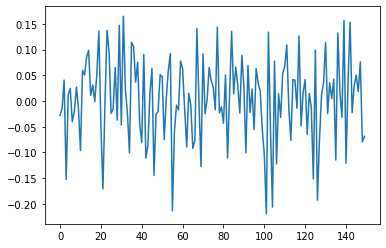

In [8]:
plt.figure();
plt.plot(wts)

In [9]:
which_prf_grid=1
_feature_extractor = sketch_token_features.sketch_token_feature_extractor(subject=subject, device=device,\
     which_prf_grid=which_prf_grid, \
     use_pca_feats = use_pca_st_feats, min_pct_var = min_pct_var, max_pc_to_retain = max_pc_to_retain, \
     use_lda_feats = use_lda_st_feats, lda_discrim_type = lda_discrim_type, zscore_in_groups = zscore_in_groups)

_feature_extractor.init_for_fitting(image_size=None, models=models, dtype=fpX)

Initializing for fitting
Clearing features from memory


In [10]:
mm=0
feat, d = _feature_extractor(val_stim_data, prf_params = models[mm,:], prf_model_index=mm)

Loading pre-computed features from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf.h5py
Took 23.69087 seconds to load file
Size of features array for this image set is:
(62, 150, 875)
Final size of feature matrix is:
(62, 150)


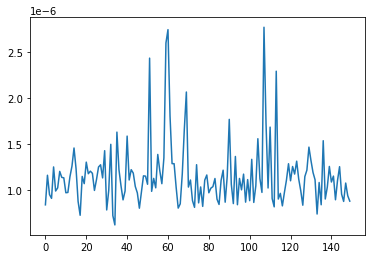

In [11]:
plt.figure();
plt.plot(np.mean(feat.detach().cpu().numpy(), axis=0))

In [12]:
features = feat.detach().cpu().numpy()
features_m = np.mean(features, axis=0, keepdims=True) #[:trn_size]
features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
features -= features_m
features /= features_s  

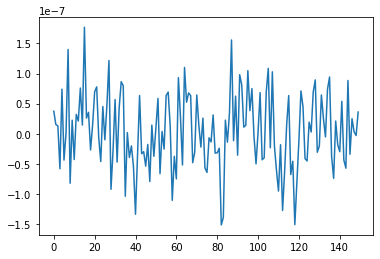

In [13]:
plt.figure();
plt.plot(np.mean(features, axis=0))

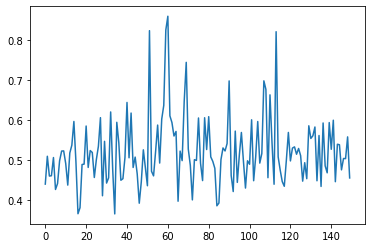

In [14]:
plt.figure();
plt.plot(np.std(features, axis=0))

In [15]:
dtype=fpX
features = np.concatenate([features, np.ones(shape=(len(features), 1), dtype=dtype)], axis=1)

In [16]:
features

array([[-0.09263413, -0.22460389, -0.12015132, ..., -0.10658877,
        -0.28702095,  1.        ],
       [-0.33456042,  1.3511527 , -0.3531356 , ..., -0.33134663,
        -0.41965201,  1.        ],
       [-0.13955301,  0.34076315, -0.05699729, ..., -0.2732999 ,
        -0.16481368,  1.        ],
       ...,
       [-0.03520036, -0.4230809 , -0.09294906, ..., -0.11424797,
        -0.33685222,  1.        ],
       [-0.1717157 ,  0.4615436 , -0.20211552, ..., -0.221561  ,
        -0.21094327,  1.        ],
       [-0.28244248, -0.4982845 , -0.40591684, ..., -0.3383118 ,
        -0.4006438 ,  1.        ]], dtype=float32)

In [17]:
features.shape

(62, 151)

In [26]:
resp = features[:,0:150] @ wts + features[:,150]*bias
resp.shape

(62,)

In [31]:
scales = np.arange(-20,20)
sim_features = np.array([features[0,:]*scales[sc] for sc in range(len(scales))])
sim_resp = sim_features[:,0:150] @ wts + sim_features[:,150]*bias

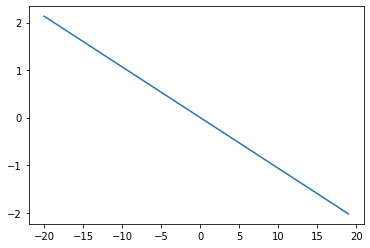

In [32]:
plt.figure();
plt.plot(scales, sim_resp)

In [46]:
delta = 0.01
sim_features = np.tile(features[0:1,:], [150,1])
for ff in range(150):
    sim_features[ff,ff] += delta
sim_resp = sim_features[:,0:150] @ wts + sim_features[:,150]*bias

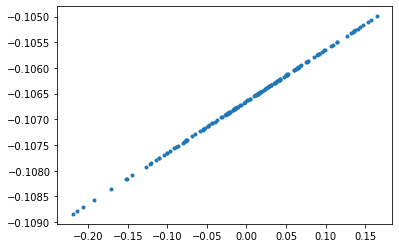

In [48]:
plt.figure();
plt.plot(wts,sim_resp,'.')

In [43]:
some_axis = np.random.normal(0,1,[150,])
delta = 0.01
step = np.arange(-20,20)
sim_features = np.tile(features[0:1,0:150], [len(step),1])
for si,ss in enumerate(step):
    sim_features[si,:] += some_axis*delta*ss
sim_features = np.concatenate([sim_features, np.ones((sim_features.shape[0],1))], axis=1)    
sim_resp = sim_features[:,0:150] @ wts + sim_features[:,150]*bias

In [49]:
bias

0.018368457

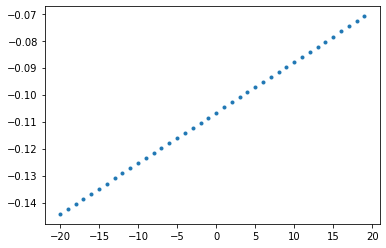

In [44]:
plt.figure();
plt.plot(step,sim_resp,'.')

In [51]:
animacy_axis = np.random.normal(0,1,(150,))
steps = np.arange(-10,10)
stimuli = np.array([animacy_axis*step for step in steps])
stimuli.shape

(20, 150)

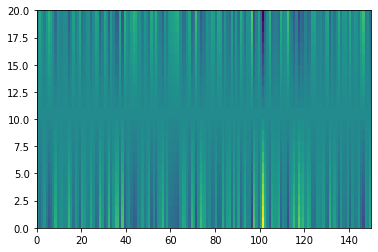

In [52]:
plt.figure();
plt.pcolormesh(stimuli)

In [117]:
noise_main = 50
noise_oversample = 0.5
n_vox = 100
features_to_oversample = np.arange(5)
perturb_weights = noise_main*np.random.normal(0,1,(n_vox, len(animacy_axis)))
perturb_weights[:,features_to_oversample] = noise_oversample*np.random.normal(0,1,\
                                                                  (n_vox, len(features_to_oversample)))
feature_tuning = np.tile(animacy_axis[np.newaxis,:], [n_vox,1]) + perturb_weights
feature_tuning.shape

(100, 150)

In [117]:
noise_main = 50
noise_oversample = 0.5
n_vox = 100
features_to_oversample = np.arange(5)
perturb_weights = noise_main*np.random.normal(0,1,(n_vox, len(animacy_axis)))
perturb_weights[:,features_to_oversample] = noise_oversample*np.random.normal(0,1,\
                                                                  (n_vox, len(features_to_oversample)))
feature_tuning = np.tile(animacy_axis[np.newaxis,:], [n_vox,1]) + perturb_weights
feature_tuning.shape

(100, 150)

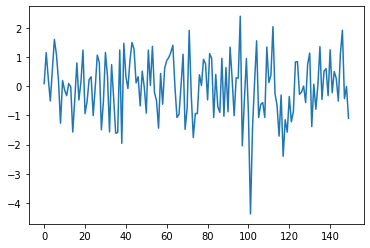

In [118]:
plt.figure();
plt.plot(animacy_axis)

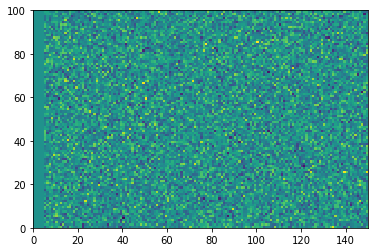

In [119]:
plt.figure();
plt.pcolormesh(feature_tuning)

In [120]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(feature_tuning.T)
scores = pca.transform(feature_tuning.T)
scores.shape
pca_wts = pca.components_
ev = pca.explained_variance_
ev = ev/np.sum(ev)*100

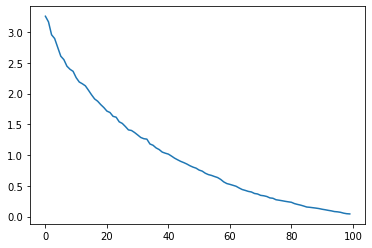

In [121]:
plt.figure();
plt.plot(ev)

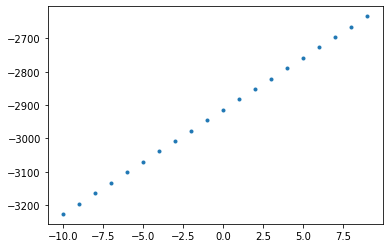

In [125]:
resp = stimuli @ feature_tuning.T
pca.fit(resp_scores)
resp_scores = pca.transform(resp)

plt.figure();
plt.plot(steps, resp_scores[:,0],'.')
# plt.plot(steps, resp[:,0],'.')

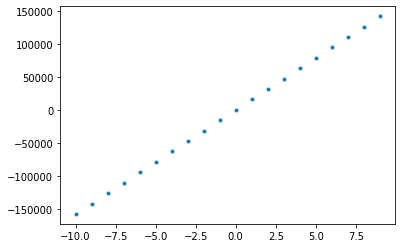

In [106]:
plt.figure();
plt.plot(steps, np.sum(resp, axis=1),'.')
# plt.plot(steps, resp[:,0],'.')

In [ ]:
orient_prefs = 